This notebook collects all the game ID's from the Steam Web API: https://steamcommunity.com/dev and additional informattion from the Storefront API: https://wiki.teamfortress.com/wiki/User:RJackson/StorefrontAPI.
Then 

In [6]:
import json
from urllib.request import urlopen
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
from ast import literal_eval

# variables
scrape_details = True # if data should be scraped or loaded from csv
num_apps = 1000 # number of reviews to scrape, if 0 all reviews will be scraped
# 5 minute bucket for 200 Requests, 100000 per day

all_games_url = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"
review_url = "https://store.steampowered.com/appreviews/"
app_details_url = "https://store.steampowered.com/api/appdetails?appids="

In [7]:
# either scraping the data
if scrape_details:
        
    # get all app ID
    with urlopen(all_games_url) as url:
        apps = pd.json_normalize(json.load(url)["applist"], record_path =['apps'])
    
    # pre-clean empty names
    apps = apps.drop(apps[apps.name == ""].index)

    # check if all should be scraped
    if num_apps == 0: num_apps = len(apps)
    
    # if data file not  exists 
    if not os.path.exists("raw_data.csv"):
        
        # initialize empty one
        df = pd.DataFrame()
    
    else: 
        # read out    
        df = pd.read_csv('raw_data.csv', index_col=0)
        
        # select all new apps
        apps = apps.drop(apps[apps.appid.isin(df.appid)].index)
    
    # select random num_apps of all apps
    apps = apps.sample(frac=1).head(num_apps)
    
    reviews = pd.DataFrame()
    details = pd.DataFrame()
    
    # iterate through the appids
    for i, appid in enumerate(tqdm(apps.appid)):
    
        # every 200 API calls wait 5 minutes to reset the bucket
        if i%200 == 0 and i != 0:
            time.sleep(300)
        
        # create specific detail url
        with urlopen(app_details_url + str(appid)) as url:
            
            # collect details
            app_details = json.load(url)[str(appid)]
            
            # if api call was successfull
            if app_details["success"]:
                
                # concat to details frame
                details = pd.concat([details, pd.DataFrame([app_details["data"]])])
                
                # create specific review url
                with urlopen(review_url + str(appid) + "?json=1") as url:
                    
                    # concat to reviews frame
                    reviews = pd.concat([reviews, pd.DataFrame([json.load(url)['query_summary']])])
            
            else:
                # if detail call were not successfull delete row in app df
                apps = apps.drop(apps[apps.appid == appid].index) 

    # concate new data together and append to old data
    df = pd.concat([df, 
                    pd.concat([apps.reset_index(drop=True), 
                    reviews.reset_index(drop=True),
                    details.drop(["steam_appid", "name"], axis = 1).reset_index(drop=True)],
                       axis = 1)], ignore_index = True)

    # overwrite csv
    df.to_csv('raw_data.csv')

# or only reading
else:
    df = pd.read_csv('raw_data.csv')


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Cleaning the data
# games that have no reviews
df = df.drop(df[df.total_reviews == 0].index).reset_index(drop=True)
# games for which information was not fetched
df.to_csv('clean_data.csv')

Text(0.5, 1.0, 'Score distribution')

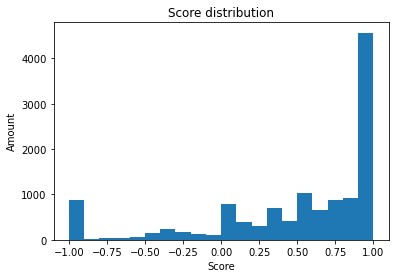

In [ ]:
# plot distribution
plt.hist((df.total_positive - df.total_negative)/df.total_reviews, bins=20)
plt.xlabel("Score")
plt.ylabel("Amount")
plt.title("Score distribution")

-20.69651270250066 804.6393098002613


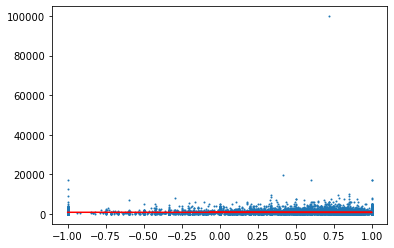

In [ ]:
# get prices
prices = []

# iterate through rows
for index, row in df.iterrows():
    # if free to play, set price 0
    if row.is_free:
        prices.append(0)
    
    else:
        # try to read the entry as a dictionary
        try:
            dict = literal_eval(str(row.price_overview).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
        
        # if possible
        else: 
            
            # if currency is not EUR
            if dict["currency"] != "EUR":
                
                # delete row
                df.drop(index, inplace=True)
           
            # get price
            else:
                prices.append(dict["initial"])

# calculate score
score = (df.total_positive - df.total_negative)/df.total_reviews
plt.scatter(score, prices, s = 1)

# calculate linear regression
m, b = np.polyfit(score, prices, 1)
print(m, b)

# regression line
plt.plot(score, m*score+b, color='red')